In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

# load xgb model
xgb_cv = xgb.Booster()
xgb_cv.load_model('xgb_cv_model.json')

# import knockout stage data
ko_stage = pd.read_csv('C:\\Users\\shann\\Documents\\GitHub\\15095-project\\data\\knockout_stages.csv')
ko_stage_df = pd.read_csv('C:\\Users\\shann\\Documents\\GitHub\\15095-project\\data\\knockout_stages.csv')
X_train = pd.read_csv('C:\\Users\\shann\\Documents\\GitHub\\15095-project\\data\\X_train.csv')
X_test = pd.read_csv('C:\\Users\\shann\\Documents\\GitHub\\15095-project\\data\\X_test.csv')
y_train = pd.read_csv('C:\\Users\\shann\\Documents\\GitHub\\15095-project\\data\\y_train.csv')
y_test = pd.read_csv('C:\\Users\\shann\\Documents\\GitHub\\15095-project\\data\\y_test.csv')

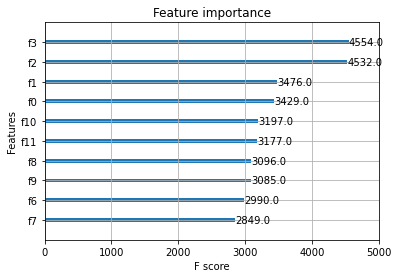

In [108]:
# import plot_importance
from xgboost import plot_importance
from matplotlib import pyplot as plt
# plot feature importance
plot_importance(xgb_cv, max_num_features=10)
plt.show()

In [141]:
feat_importances = pd.DataFrame({xgb_cv.get_fscore().values(),
              }, columns=X_train.columns[0:179])
feat_importances = feat_importances.T
feat_importances.columns = ['importance']
feat_importances = feat_importances.sort_values(by=['importance'], ascending=False)
#len(xgb_cv.get_fscore().values()),len(X_train.columns)

In [149]:
# plotly plot of feature importance - top 10
import plotly.express as px

fig = px.bar(feat_importances[0:15], x=feat_importances.index[0:15], y='importance')
fig.update_layout(
    title="Feature Importance",
    xaxis_title="Feature",
    yaxis_title="Importance",
    font=dict(
        family="Courier New, monospace",
        size=12,
        color="#7f7f7f"
    )
)
fig.show()

In [ ]:

feat_importances.head(2)

In [4]:
# get weather data for knockout stage
ko_stage['city'] = ko_stage['city'].str.lower()
ko_stage['date'] = pd.to_datetime(ko_stage['date'])
ko_stage['population'] = ko_stage['city'].map({'al rayyan': 759000, 'doha': 2382000, 
'al khor': 214767, 'al wakrah': 94272, 'lusail': 198600}) 

In [5]:
# import geopy and geolocator
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="GetLoc")

# get latitude and longitude for each city
ko_stage['lat'] = ko_stage['city'].apply(lambda x: geolocator.geocode(x).latitude)
ko_stage['lng'] = ko_stage['city'].apply(lambda x: geolocator.geocode(x).longitude)

In [6]:
from meteostat import Point
from meteostat import Daily
# get weather data for matches
ko_stage['avg_temp'] = 0
for i in range(len(ko_stage)):
    ko_stage['avg_temp'][i] = Daily(Point(ko_stage['lat'][i],ko_stage['lng'][i]), 
    start=ko_stage['date'][i], end=ko_stage['date'][i]).fetch()['tavg']

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
ko_stage.drop(['date','tournament','city','country',
'neutral_location','lat','lng'],axis = 1, inplace = True)

In [10]:
# import standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [12]:
ko_stage = pd.get_dummies(ko_stage)
for col in set(X_train.columns) - set(ko_stage.columns):
    ko_stage[col] = 0

ko_stage = ko_stage[X_train.columns]

In [13]:
ko_stage_scaled = scaler.transform(ko_stage)

In [17]:

xgb_cv_pred = xgb_cv.predict(xgb.DMatrix(ko_stage_scaled))
xgb_cv_pred = pd.DataFrame(xgb_cv_pred)
xgb_cv_pred.rename(columns={0:'draw', 1:'home_loss', 2:'home_win'}, inplace=True)
xgb_cv_pred['home_team'] = ko_stage_df['home_team']
xgb_cv_pred['away_team'] = ko_stage_df['away_team']
xgb_cv_pred=xgb_cv_pred[['home_team','away_team','home_win','draw','home_loss']]
# sort new_xgb_pred by home_team and then away_team
xgb_cv_pred = xgb_cv_pred.sort_values(by=['home_team','away_team'])
xgb_cv_pred.to_csv('xgb_knockout_preds.csv', index=False)


In [19]:
xgb_cv_pred

,home_team,away_team,home_win,draw,home_loss
1,Argentina,Australia,0.997543,0.001900,0.000558
5,Brazil,Korea Republic,0.908753,0.080863,0.010385
3,England,Senegal,0.998027,0.001770,0.000203
2,France,Poland,0.944143,0.050796,0.005062
4,Japan,Croatia,0.011556,0.126284,0.862160
6,Morocco,Spain,0.071835,0.916580,0.011586
0,Netherlands,USA,0.983484,0.012229,0.004287
7,Portugal,Switzerland,0.977792,0.009458,0.012750


## Quarterfinals

In [24]:
quarterfinals = pd.read_csv('../data/quarter_finals.csv')
quarterfinals_df= pd.read_csv('../data/quarter_finals.csv')

In [25]:
# get weather data for knockout stage
quarterfinals['city'] = quarterfinals['city'].str.lower()
quarterfinals['date'] = pd.to_datetime(quarterfinals['date'])
quarterfinals['population'] = quarterfinals['city'].map({'al rayyan': 759000, 'doha': 2382000, 
'al khor': 214767, 'al wakrah': 94272, 'lusail': 198600}) 

In [26]:
# import geopy and geolocator
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="GetLoc")

# get latitude and longitude for each city
quarterfinals['lat'] = quarterfinals['city'].apply(lambda x: geolocator.geocode(x).latitude)
quarterfinals['lng'] = quarterfinals['city'].apply(lambda x: geolocator.geocode(x).longitude)

In [27]:
from meteostat import Point
from meteostat import Daily
# get weather data for matches
quarterfinals['avg_temp'] = 0
for i in range(len(quarterfinals)):
    quarterfinals['avg_temp'][i] = Daily(Point(quarterfinals['lat'][i],quarterfinals['lng'][i]), 
    start=quarterfinals['date'][i], end=quarterfinals['date'][i]).fetch()['tavg']

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
quarterfinals.drop(['date','tournament','city','country',
'neutral_location','lat','lng'],axis = 1, inplace = True)

In [29]:
# import standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

quarterfinals = pd.get_dummies(quarterfinals)
for col in set(X_train.columns) - set(quarterfinals.columns):
    quarterfinals[col] = 0

quarterfinals = quarterfinals[X_train.columns]

In [30]:
quarterfinals_scaled = scaler.transform(quarterfinals)

In [40]:
xgb_cv_pred = xgb_cv.predict(xgb.DMatrix(quarterfinals_scaled))
xgb_cv_pred = pd.DataFrame(xgb_cv_pred)
xgb_cv_pred.rename(columns={0:'draw', 1:'home_loss', 2:'home_win'}, inplace=True)
xgb_cv_pred['home_team'] = quarterfinals_df['home_team']
xgb_cv_pred['away_team'] = quarterfinals_df['away_team']
xgb_cv_pred=xgb_cv_pred[['home_team','away_team','home_win','draw','home_loss']]
# sort new_xgb_pred by home_team and then away_team
xgb_cv_pred = xgb_cv_pred.sort_values(by=['home_team','away_team'])
xgb_cv_pred.to_csv('xgb_quarterfinal_preds.csv', index=False)


In [32]:
xgb_cv_pred

,home_team,away_team,home_win,draw,home_loss
1,Croatia,Brazil,0.029120,0.870400,0.100480
3,England,France,0.229328,0.135802,0.634870
2,Morocco,Portugal,0.193334,0.046348,0.760318
0,Netherlands,Argentina,0.062675,0.042961,0.894364


## Semi-finals


In [7]:
semifinals = pd.read_csv('../data/semi_finals.csv')
semifinals_df= pd.read_csv('../data/semi_finals.csv')

# get weather data for knockout stage
semifinals['city'] = semifinals['city'].str.lower()
semifinals['date'] = pd.to_datetime(semifinals['date'])

# import geopy and geolocator
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="GetLoc")

# get latitude and longitude for each city
semifinals['lat'] = semifinals['city'].apply(lambda x: geolocator.geocode(x).latitude)
semifinals['lng'] = semifinals['city'].apply(lambda x: geolocator.geocode(x).longitude)

from meteostat import Point
from meteostat import Daily
# get weather data for matches
semifinals['avg_temp'] = 25
for i in range(len(semifinals)):
    semifinals['avg_temp'][i] = Daily(Point(semifinals['lat'][i],semifinals['lng'][i]), 
    start=semifinals['date'][i], end=semifinals['date'][i]).fetch()['tavg']

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
# impute missing values with mean
semifinals['avg_temp'] = 22

In [9]:
semifinals.drop(['date','tournament','city','country',
'neutral_location','lat','lng'],axis = 1, inplace = True)

# import standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

semifinals = pd.get_dummies(semifinals)
for col in set(X_train.columns) - set(semifinals.columns):
    semifinals[col] = 0

semifinals = semifinals[X_train.columns]

semifinals_scaled = scaler.transform(semifinals)

In [10]:
xgb_cv_pred = xgb_cv.predict(xgb.DMatrix(semifinals_scaled))
xgb_cv_pred = pd.DataFrame(xgb_cv_pred)
xgb_cv_pred.rename(columns={0:'draw', 1:'home_loss', 2:'home_win'}, inplace=True)
xgb_cv_pred['home_team'] = semifinals_df['home_team']
xgb_cv_pred['away_team'] = semifinals_df['away_team']
xgb_cv_pred=xgb_cv_pred[['home_team','away_team','home_win','draw','home_loss']]
# sort new_xgb_pred by home_team and then away_team
xgb_cv_pred = xgb_cv_pred.sort_values(by=['home_team','away_team'])
xgb_cv_pred.to_csv('xgb_semifinal_preds.csv', index=False)


In [11]:
xgb_cv_pred

,home_team,away_team,home_win,draw,home_loss
0,Argentina,Croatia,0.920579,0.005820,0.073601
1,France,Morocco,0.999172,0.000305,0.000523


## Finals

In [54]:
finals = pd.read_csv('../data/finals.csv')
finals_df= pd.read_csv('../data/finals.csv')

# get weather data for knockout stage
finals['city'] = finals['city'].str.lower()
finals['date'] = pd.to_datetime(finals['date'])

# import geopy and geolocator
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="GetLoc")

# get latitude and longitude for each city
finals['lat'] = finals['city'].apply(lambda x: geolocator.geocode(x).latitude)
finals['lng'] = finals['city'].apply(lambda x: geolocator.geocode(x).longitude)

from meteostat import Point
from meteostat import Daily
# get weather data for matches
finals['avg_temp'] = 0
for i in range(len(finals)):
    finals['avg_temp'][i] = Daily(Point(finals['lat'][i],finals['lng'][i]), 
    start=finals['date'][i], end=finals['date'][i]).fetch()['tavg']


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long long'

In [55]:
# impute missing values with mean
finals['avg_temp'] = 25

In [56]:
finals.drop(['date','tournament','city','country',
'neutral_location','lat','lng'],axis = 1, inplace = True)

# import standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

finals = pd.get_dummies(finals)
for col in set(X_train.columns) - set(finals.columns):
    finals[col] = 0

finals = finals[X_train.columns]

finals_scaled = scaler.transform(finals)

In [57]:
xgb_cv_pred = xgb_cv.predict(xgb.DMatrix(finals_scaled))
xgb_cv_pred = pd.DataFrame(xgb_cv_pred)
xgb_cv_pred.rename(columns={0:'draw', 1:'home_loss', 2:'home_win'}, inplace=True)
xgb_cv_pred['home_team'] = finals_df['home_team']
xgb_cv_pred['away_team'] = finals_df['away_team']
xgb_cv_pred=xgb_cv_pred[['home_team','away_team','home_win','draw','home_loss']]
# sort new_xgb_pred by home_team and then away_team
xgb_cv_pred = xgb_cv_pred.sort_values(by=['home_team','away_team'])
xgb_cv_pred.to_csv('xgb_final_preds.csv', index=False)


In [58]:
xgb_cv_pred

,home_team,away_team,home_win,draw,home_loss
1,Argentina,Portugal,0.499648,0.029688,0.470664
0,Brazil,France,0.361876,0.086350,0.551774
